In [1]:
from fastai.vision.all import *
import PIL

/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fastai.layers import *

In [3]:
import torch
import models
from data import build_loader
from torchvision import transforms
from torchvision.transforms import InterpolationMode

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.


In [4]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [5]:
def label_func(x):
    return x.parent.name

In [6]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [7]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [8]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [9]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [10]:
path = Path('/home/yog/SWIN Test Data/')

In [11]:
files = get_image_files(path)

In [12]:
labels = list(set(files.map(label_func)))
len(labels)

10

In [13]:
t = []

t.append(transforms.Resize((384, 384), interpolation=InterpolationMode.BICUBIC))
t.append(transforms.ToTensor())
t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
data_transforms = transforms.Compose(t)

In [14]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize((384, 384)), ToTensor], 
                        batch_size = 16,
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [15]:
# dls.show_batch()

In [16]:
swin_model = models.swin_transformer_v2.SwinTransformerV2(img_size=384,
                                  patch_size=4,
                                  in_chans=3,
                                  num_classes=1000,
                                  embed_dim=192,
                                  depths=[2, 2, 18, 2],
                                  num_heads=[6, 12, 24, 48],
                                  window_size=24,
                                  mlp_ratio=4.0,
                                  qkv_bias=True,
                                  drop_rate=0.0,
                                  drop_path_rate=0.2,
                                  ape=False,
                                  patch_norm=True,
                                  use_checkpoint=True,
                                  pretrained_window_sizes=[12, 12, 12, 6])

/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
swin_model.load_state_dict(torch.load('/home/yog/swin.back/ckpt_epoch_29.pth')['model'])

<All keys matched successfully>

In [18]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)
    
    def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
        res = self.predict(item, rm_type_tfms=None, with_input=False)
        if res[0] == tensor(0):
            SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
        else:
            SiameseImage(item[0], item[1], 'Prediction: Similar').show()
        return res

In [19]:
#x_convs = self.convs[0](Variable(torch.from_numpy(X).type(torch.FloatTensor)))

#if len(self.convs) > 1:
 #   for conv in self.convs[1:]:
  #      x_convs = conv(x_convs)

In [20]:
# encoder = create_body(resnet152(), cut=-2)
encoder = swin_model


In [21]:
class Head(nn.Module):
    def __init__(self, bn_num=3072):
        super(Head, self).__init__()
        self.flatten = nn.Flatten()
        self.bn1 = torch.nn.BatchNorm1d(bn_num, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout1 = torch.nn.Dropout(p=0.5, inplace=False)
        self.linear1 = torch.nn.Linear(in_features=bn_num, out_features=512, bias=True)
        self.relu = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dropout2 = torch.nn.Dropout(p=0.5, inplace=False)
        self.linear2 = torch.nn.Linear(in_features=512, out_features=2, bias=True)
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

In [22]:
head = Head(bn_num=3072)
model = SiameseModel(encoder, head).cuda()

In [23]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [24]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [25]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [26]:
learn.freeze()

In [ ]:
# learn.lr_find()

In [28]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.892614,0.689627,0.514970,02:34
1,0.845447,0.665850,0.598802,02:34


/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(8, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.833831,0.616965,0.700599,03:06
1,0.790979,0.553797,0.736527,03:06
2,0.715402,0.401617,0.898204,03:05
3,0.683520,0.314863,0.928144,03:06
4,0.628517,0.289664,0.922156,03:07
5,0.600425,0.257310,0.940120,03:06
6,0.576962,0.249941,0.934132,03:05
7,0.569902,0.250216,0.934132,03:06


/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home

In [31]:
learn.save('swin_siamese')

Path('models/swin_siamese.pth')

## Testing

In [32]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/yog/anaconda3/envs/fastai-gpu/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


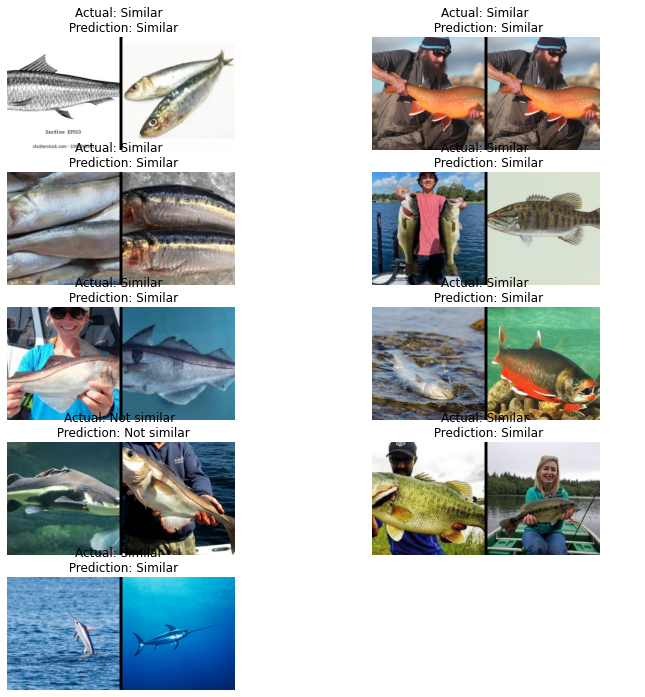

In [33]:
learn.show_results()


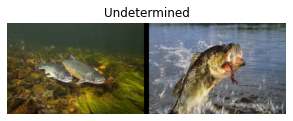

In [76]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

In [35]:
!pip install jupyterlab-widgets
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 14.2 MB/s eta 0:00:00
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-09v0t9eo.log


In [38]:
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='.jpg', multiple=True)
display(upload)

FileUpload(value=(), accept='.jpg', description='Upload', multiple=True)